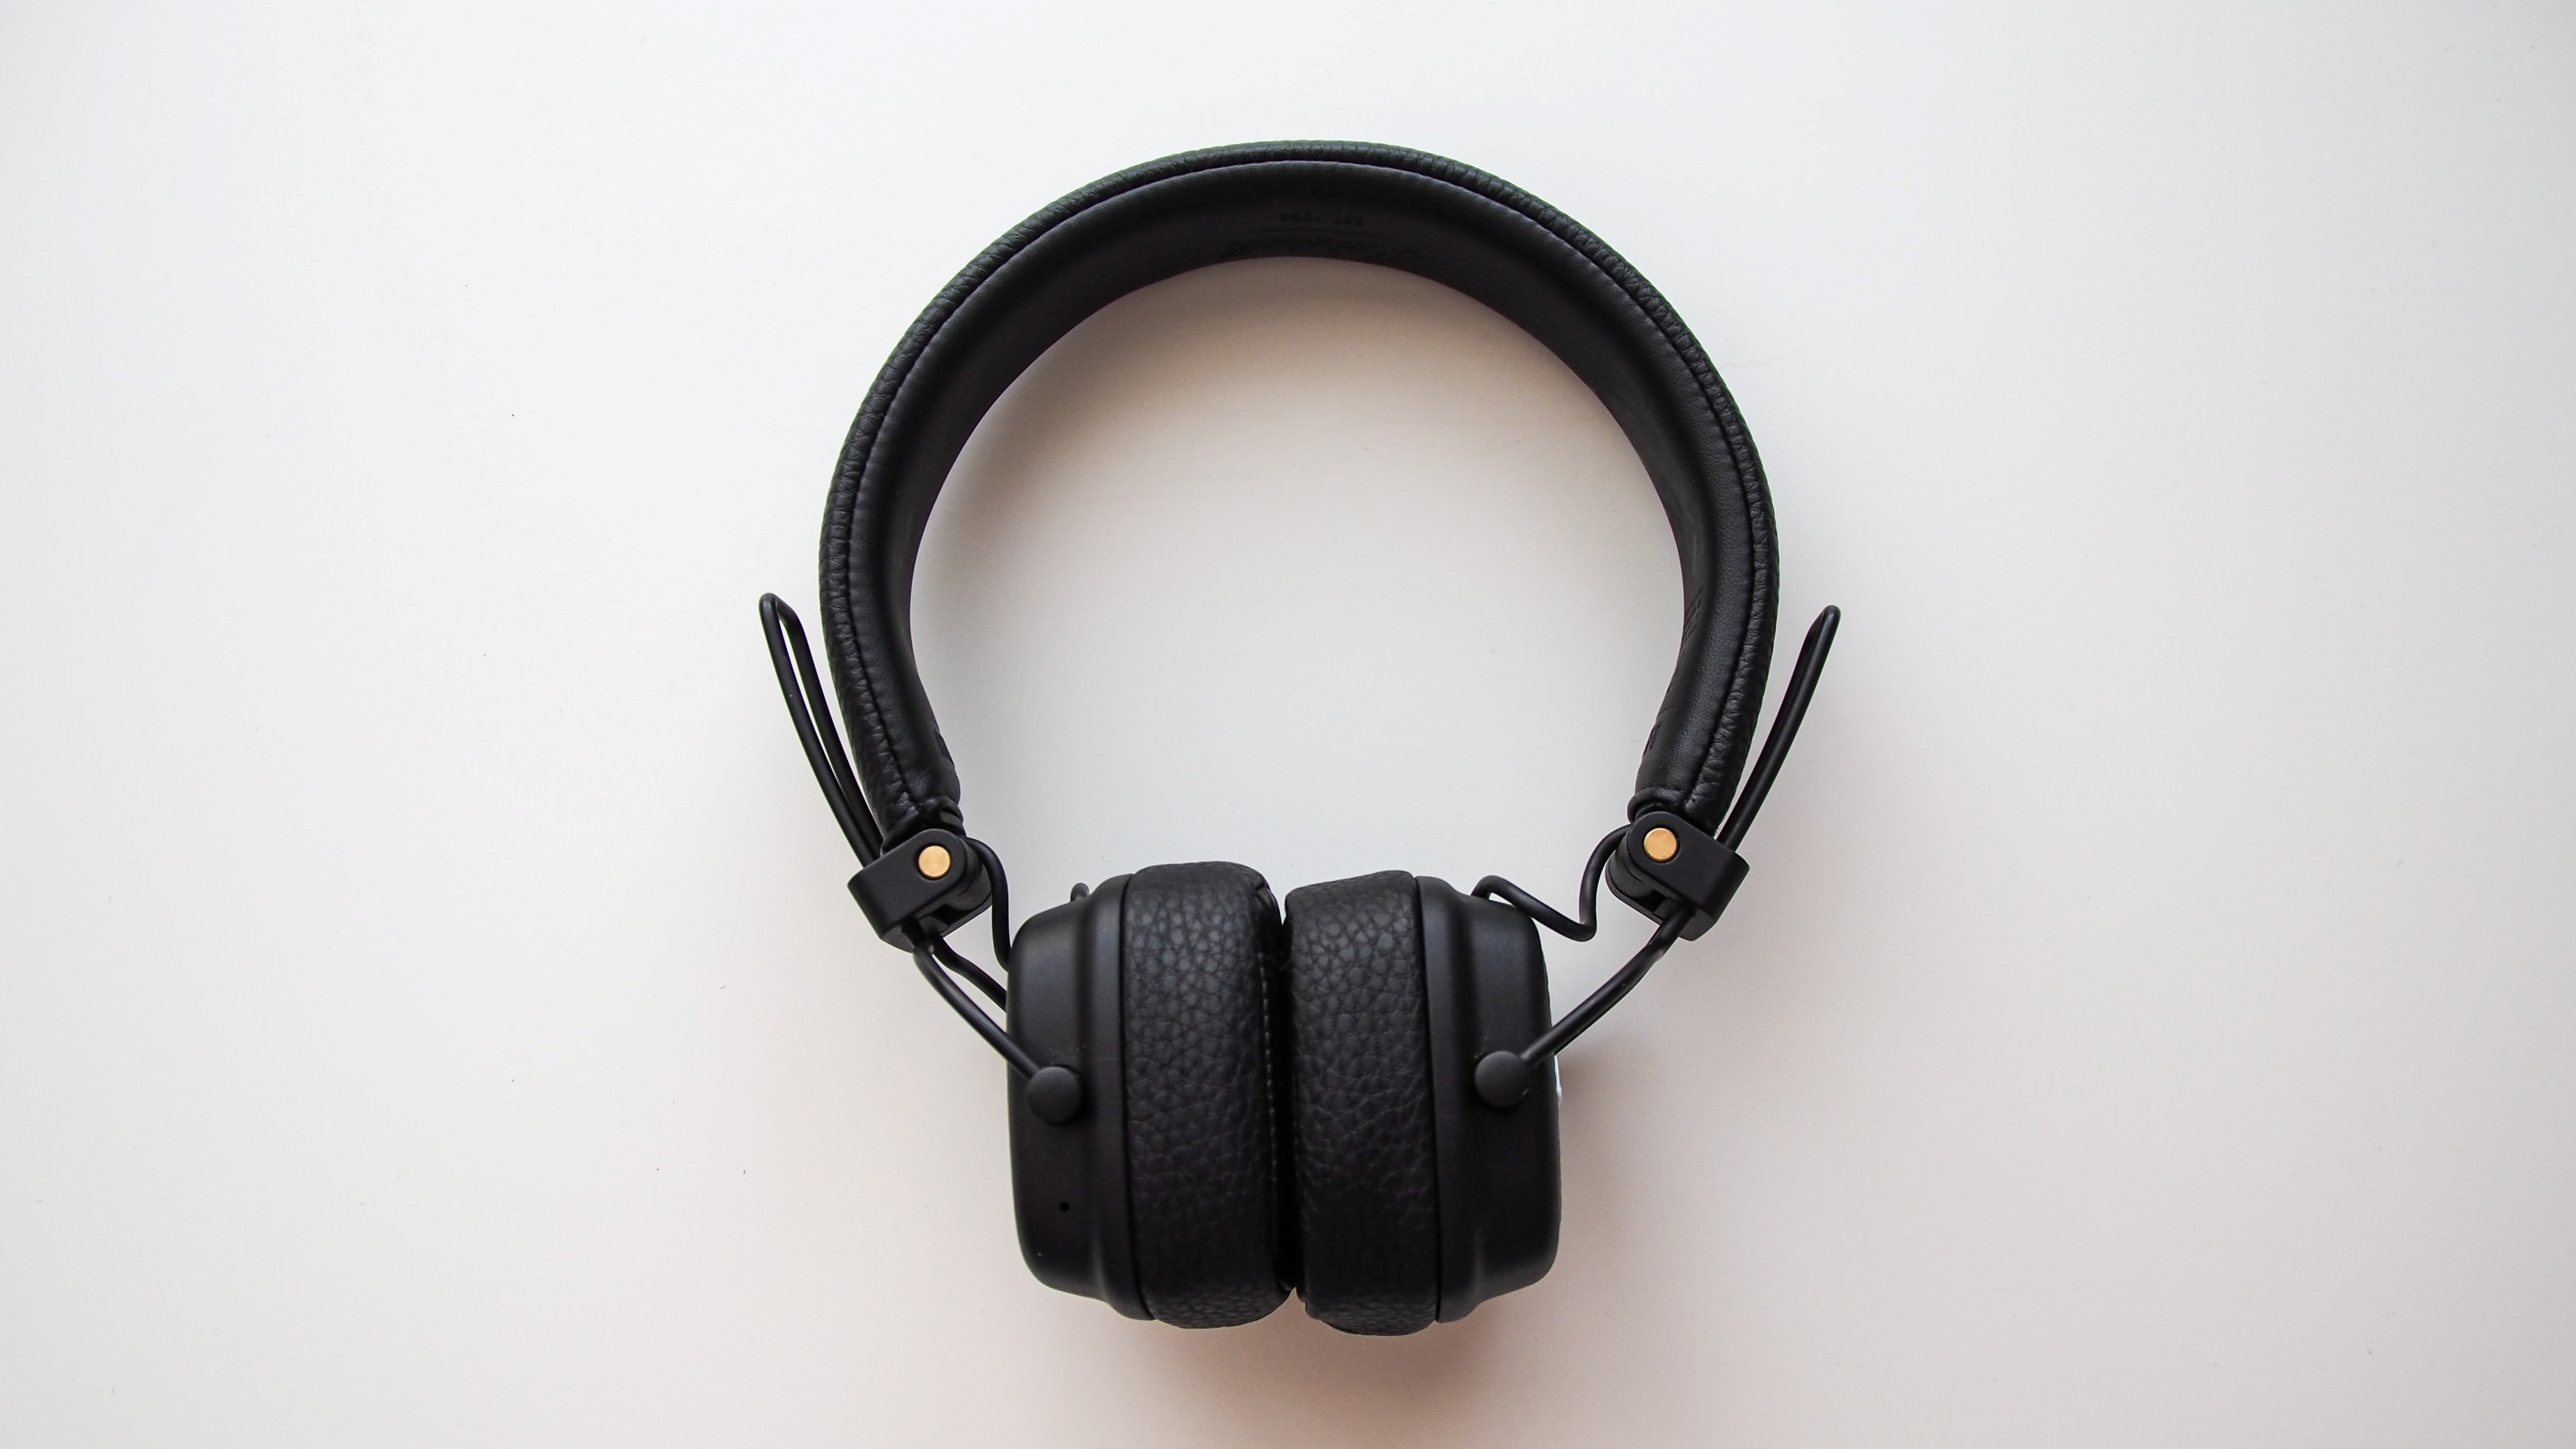

In [18]:
# ! pip install librosa --quiet
import numpy as np
import matplotlib.pyplot as plt
# from IPython.display import Audio, display

# ! pip install pyLDAvis -q
import pandas as pd
import json
# import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12})
import altair as alt
import statsmodels.formula.api as smf
import nltk
import string
from gensim import corpora, models
# import pyLDAvis
# import pyLDAvis.gensim_models
import warnings
warnings.simplefilter(action='ignore')

import importlib
# import access
# from access import *
# importlib.reload(access)

import music
# importlib.reload(music)

In [15]:
# data provided from assignment
music_df = pd.read_csv('pt1_files\music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)
music_df = music_df.rename(columns={'pos': 'pos_sentiment', 'neg': 'neg_sentiment', 'neu': 'neu_sentiment'})

print(music_df.columns)
music_df.head(2)

Index(['lyrics', 'num_syllables', 'pos_sentiment', 'year', 'fog_index',
       'flesch_index', 'num_words', 'num_lines', 'title', 'f_k_grade',
       'artist', 'difficult_words', 'num_dupes', 'neg_sentiment',
       'neu_sentiment', 'compound', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'uri',
       'analysis_url', 'artist_with_features', 'year_bin', 'image', 'cluster',
       'Gender'],
      dtype='object')


,lyrics,num_syllables,pos_sentiment,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,...,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group


In [ ]:
# data directly from the https://github.com/kevinschaich/billboard
f = open('pt1_files\directdata.json')
direct_list = eval(f.read())
f.close()
direct_dict = {}
for i in range(len(direct_list)):
    direct_dict[direct_list[i]['year']] = pd.json_normalize(direct_list[i]['songs'])
direct_df = direct_dict[1950]
direct_df['year'] = 1950
for i in range(1951, 2016):
    direct_dict[i]['year'] = i
    direct_df = pd.concat([direct_df,direct_dict[i]])

In [24]:
# merging to get tag and position of song in top 100 and
music_df = music_df.rename(columns={'pos': 'pos_sentiment', 'neg': 'neg_sentiment', 'neu': 'neu_sentiment'})

direct_df = direct_df.set_index(['year','artist','title'])[['pos','tags']]
music_df = music_df.set_index(['year','artist','title'])
music_df = pd.merge(music_df,direct_df[['pos','tags']],how='left',left_index=True,right_index=True).reset_index()

In [29]:
# standardizing
standardized = music_df.copy().dropna()
for var in numerical:
    standardized[var] = (standardized[var] - standardized[var].mean())/standardized[var].std()

In [13]:
numerical = ['difficult_words','num_words','num_dupes',
'num_lines','duration_ms',
'fog_index','f_k_grade','flesch_index',
'speechiness','acousticness','instrumentalness',
'tempo','liveness','energy','danceability','loudness',
'pos_sentiment','neg_sentiment','neu_sentiment']
numerical_group = {'num_words':'words','num_dupes':'words','difficult_words':'words',
                    'num_lines':'length','duration_ms':'length',
                   'fog_index':'readability','f_k_grade':'readability','flesch_index':'readability',
                    'speechiness':'audio','acousticness':'audio','instrumentalness':'audio','tempo':'audio','liveness':'audio','energy':'audio','danceability':'audio','loudness':'audio',
                    'neg_sentiment':'sentiment','neu_sentiment':'sentiment','pos_sentiment':'sentiment'}
numerical = list(numerical)

# Horkheimer's claim
In “The Culture Industry: Enlightenment as Mass Deceoption”, Horkheimer and Adorno claim that “Culture today is infecting everything with sameness”.
They argue that while variations do exist, the variation is not true variation – rather, like a wheel spinning in place, it gives the appearance of differentiation, but there ultimately is no true difference. Either the differences are surface level (such as the extravagant use of technology in films) and do not relate to the meaning of the products themselves, or they do not varying from existing styles. Everything is created within the same pre-existing types.

Here, we will evaluate this claim of “sameness” in relation to the popular music industry, using data from the Billboard Hot 100.

## Has our music taste varied?

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
music_df_valid = music_df.dropna(subset=numerical)
X = music_df_valid[numerical]
y = music_df_valid['year']

# standardizing the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# apply pca
pca = PCA(0.95)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
print(sum(pca.explained_variance_ratio_[:3]))
print(pca.n_components_)

pcs = pca.transform(X)
music_pca = music_df_valid.copy()
for i in range(pca.n_components_):
    music_pca[f'pc{i}'] = pcs[:,i]
# reconstructed = pca.inverse_transform(pcs)

0.9576717322497605
0.43801138945960705
13


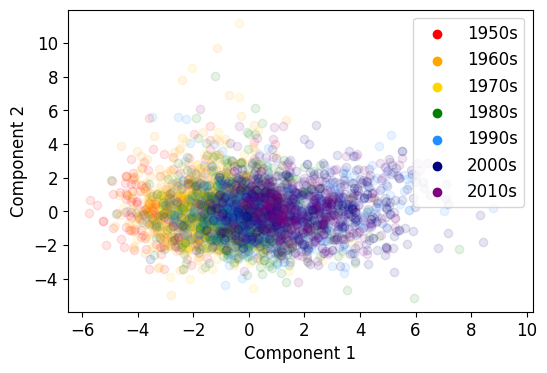

In [19]:
#| include: true
yearbin_colors = ['red','orange','gold','green','dodgerblue','navy','purple']
c = 0
plt.figure(figsize=(6,4))
for year in music_pca['year_bin'].unique():
    plt.scatter(music_pca[music_pca['year_bin']==year]['pc0'], music_pca[music_pca['year_bin']==year]['pc1'], alpha=0.1, label=year,
    c=yearbin_colors[c])
    c += 1
leg = plt.legend()
music.set_legend_alpha(leg.legendHandles)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('pca.png')

*Songs by Year*<br>
In this scatterplot, we have the first two components of a PCA decomposition of the Spotify numerical data (such as danceability, tempo, and speechiness) for each song on the Billboard Hot 100. The decade of release is represented by color. The years seem to be clustered, moving to the right with time.

There has been a general shift in our music taste over time. However, PCA decomposition loses interpretability. While Horkheimer and Adorno might argue that readability or acousticness do not capture the true content of music, I would argue that they do. The medium of music inherently communicates not only through lyrics, but also through the energy embedded in qualities such as acousticness. Thus, because the linear combination of these variables shows change over time, we start with the idea that Horkheimer and Adorno were not completely right.


## Are unique big hits imitated?

Horkheimer and Adorno argue that culture tends toward sameness through imitating what has previously demonstrated success. Therefore, songs that are different but successful should have many imitators. <br>
<br>
To see if this is true, I take the first ten years in the dataset and use their numerical metrics and PCA decomposition to create a basis that captures at least 95% of the information. From there, I find if there's a song in the next year's top ten whos residual is an outlier. Then, I repeat this for the next year, using all the previous years numerical values to create a new basis. <br>

In [30]:
standardized

,year,artist,title,lyrics,num_syllables,pos_sentiment,fog_index,flesch_index,num_words,num_lines,...,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender,pos,tags
1,1950,Andrews Sisters,I Wanna Be Loved,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.789611,-0.383199,-2.063891,-0.914840,-0.830689,...,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group,17.0,[]
3,1950,Tennessee Ernie Ford,I'll Never Be Free,Each time I hold someone new\nMy arms grow col...,135.9,0.865207,-0.383199,0.065585,-1.291226,-1.357620,...,3,spotify:track:0KnD456yC5JuweN932Ems3,https://api.spotify.com/v1/audio-analysis/0KnD...,Kay Starr,1950s,https://i.scdn.co/image/4bd427bb9181914d0fa448...,String Lover,male,20.0,[]
9,1951,Tony Bennett,Because Of You,Because of you there's a song in my heart\nBec...,131.4,1.934361,0.286939,-1.127526,-1.374867,-1.560286,...,4,spotify:track:1hVEHu6SemMvlYAP5MWkDj,https://api.spotify.com/v1/audio-analysis/1hVE...,k.d. lang,1950s,https://i.scdn.co/image/cdc8a7ef4d569d7519c127...,String Lover,male,2.0,"[jazz, pop]"
11,1951,Mario Lanza,Be My Love,"Be my love, for no one else can end this yearn...",199.8,2.107153,1.627215,-0.318274,-1.055985,-1.357620,...,4,spotify:track:6l8tdrHjXjoM2U8mxfoXnL,https://api.spotify.com/v1/audio-analysis/6l8t...,Ray Sinatra,1950s,https://i.scdn.co/image/1c44c29f91662802c4d096...,String Lover,male,5.0,[]
12,1951,Tony Bennett,"Cold, Cold Heart",I tried so hard my dear to show that you're my...,168.3,-0.182347,3.637629,-0.700875,-1.144854,-1.600819,...,4,spotify:track:6V5kMW3vhcduEgFp5TPYsG,https://api.spotify.com/v1/audio-analysis/6V5k...,Vicentico,1950s,https://i.scdn.co/image/cdc8a7ef4d569d7519c127...,String Lover,male,7.0,"[jazz, pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2015,Sam Smith,Lay Me Down,"Yes I do, I believe\nThat one day I will be, w...",244.8,-0.128349,0.286939,1.001951,-0.789378,-0.992821,...,4,spotify:track:7E7sAg5qPv0cObXCWRsYMJ,https://api.spotify.com/v1/audio-analysis/7E7s...,John Legend,2010s,https://i.scdn.co/image/6318ebb61a9105a86c0add...,String Lover,male,81.0,[pop]
4017,2015,Big Sean,Blessings,"Look, I feel blessed\nWay up I feel blessed, w...",1050.3,0.746413,1.627215,-0.318274,2.707871,1.722900,...,4,spotify:track:4E92bmgFiHxvy2SNjXjC3b,https://api.spotify.com/v1/audio-analysis/4E92...,Drake,2010s,https://i.scdn.co/image/7af4c101861c482e6fdd9f...,Poetic,male,88.0,[]
4024,2015,Mr. Probz,Waves,My face above the water\nMy feet can't touch t...,169.2,0.357629,-1.053337,-0.872039,-1.244178,-1.195487,...,4,spotify:track:5Sf3GyLEAzJXxZ5mbCPXTu,https://api.spotify.com/v1/audio-analysis/5Sf3...,Robin Schulz,2010s,https://i.scdn.co/image/261cf047c334ad684d0c8e...,String Lover,male,95.0,[pop]
4025,2015,Ne-Yo,She Knows,You know from the moment she turned around\nSh...,217.8,-0.905916,0.286939,1.001951,-0.893930,-1.033355,...,4,spotify:track:0XETcdHr7EkjfoZFSj6Asv,https://api.spotify.com/v1/audio-analysis/0XET...,Juicy J,2010s,https://i.scdn.co/image/d48ffaffc20a3c76f79d81...,Poetic,male,97.0,[electronic/dance]


In [33]:
past_df

,year,pos,difficult_words,num_words,num_dupes,num_lines,duration_ms,fog_index,f_k_grade,flesch_index,...,acousticness,instrumentalness,tempo,liveness,energy,danceability,loudness,pos_sentiment,neg_sentiment,neu_sentiment
1,1950,17.0,0.603473,-0.914840,0.224077,-0.830689,-0.491784,-0.383199,1.824716,-2.063891,...,2.640254,-0.171507,1.908502,-0.163237,-2.942076,-1.721792,-1.700209,0.789611,-0.577127,-0.319348
3,1950,20.0,-0.840265,-1.291226,-1.358843,-1.357620,-1.171394,-0.383199,-0.184854,0.065585,...,2.028618,-0.171507,-1.345301,-0.382561,-2.423400,0.402178,-1.376400,0.865207,1.254602,-1.703819
9,1951,2.0,-1.032763,-1.374867,-1.249676,-1.560286,0.255504,0.286939,1.154859,-1.127526,...,2.644101,-0.148520,-1.741804,-0.492223,-2.220207,-2.410986,-0.830309,1.934361,-1.080503,-1.021616
11,1951,5.0,-0.695891,-1.055985,-1.140509,-1.357620,-0.285780,1.627215,0.819931,-0.318274,...,2.774891,-0.171308,-0.311723,-0.072927,-1.904724,-2.461109,-2.181117,2.107153,-0.255526,-1.774045
12,1951,7.0,-0.888390,-1.144854,-1.358843,-1.600819,-0.526658,3.637629,1.824716,-0.700875,...,2.455609,-0.171359,-1.640761,-0.350307,-2.498260,-1.395992,-1.851600,-0.182347,0.905035,-0.479866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,2014,92.0,3.587197,1.421887,-0.430924,1.074370,-0.113293,0.957077,0.485003,-0.189901,...,-0.763749,-0.171507,-0.086596,0.984989,0.784904,0.840756,0.738574,-0.355140,0.094041,0.262531
3946,2014,93.0,-0.359019,-0.057518,0.551577,0.061041,-0.415906,-0.383199,-1.189639,1.130324,...,-0.969378,-0.171507,1.510055,1.243017,1.726006,-0.844636,1.134174,-0.765522,-0.702971,1.215609
3947,2014,94.0,-1.080888,-0.329352,0.715327,-0.222691,-0.163754,-0.383199,-1.189639,1.130324,...,-0.525634,-0.171507,0.334855,-0.584468,0.517545,-0.230627,1.466694,-1.175904,-0.758902,1.626937
3948,2014,95.0,2.095335,1.688493,0.333244,1.479702,1.570121,0.286939,0.150074,-0.062787,...,-0.857995,0.675622,2.447910,0.778566,-1.038482,-1.383461,-1.057096,-0.387538,-0.800849,0.934702


1.5789734375990465

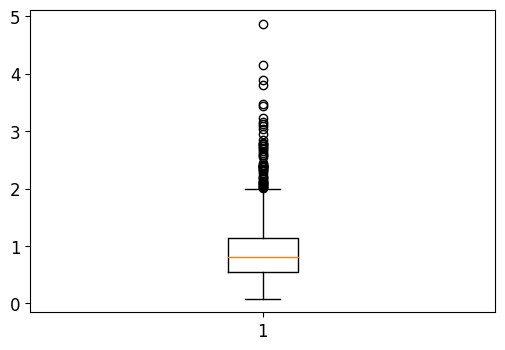

In [31]:
#| output: false

# build a PCA for the past years, find a song whos vector does not fit well into the existing PCA
all_reconstruct_err = []
for i in range(1960, 2016): # need ten years to start w
    past_df = standardized[['year','pos']+numerical].query('year < @i')
    pca = PCA(0.95)
    pca.fit(past_df[numerical])
    # print(i, sum(pca.explained_variance_ratio_), pca.n_components_)

    current_df = standardized.query('year == @i')#.query('pos < 10')
    current_pca = pca.transform(current_df[numerical])
    current_reconstruct = pca.inverse_transform(current_pca)
    current_reconstruct_err = np.linalg.norm(current_df[numerical] - current_reconstruct, axis=1)
    all_reconstruct_err.extend(current_reconstruct_err)
# find what residuals stand out
plt.boxplot(all_reconstruct_err)
np.percentile(all_reconstruct_err, 90)

In [32]:
standardized['reconstruct_err'] = [0]*len(standardized.query('year < 1960')) + all_reconstruct_err
influential = standardized.query('reconstruct_err >= 2').query('pos < 10')